# Tyre Degredation in F1 2025
- In this notebook we will hypothesise and thereby confirm the trends in tyre degredation of F1 teams and drivers across raceweekend throughout a season.
- The initial analysis will feature the most abrasive or (/and) tyre energy heavy tracks on the calendar:
    - Jeddah, Saudi Arabia `(focus of this notebook)`
    - Sakhir, Bahrain
    - Silverstone, United Kingdom
    - Catalunya, Spain
    - Austin, United States of America

In [163]:
import fastf1
from fastf1.plotting import get_driver_color

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

### Notebook Configs

In [12]:
DATAPATH = Path("data")
DATAPATH.mkdir(exist_ok=True)

### Loading the Event

In [13]:
jeddah_2025 = fastf1.get_event(
    year=2025,
    gp="saudiarabia"
)
jeddah_2025

RoundNumber                                                    5
Country                                             Saudi Arabia
Location                                                  Jeddah
OfficialEventName    FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2025
EventDate                                    2025-04-20 00:00:00
EventName                               Saudi Arabian Grand Prix
EventFormat                                         conventional
Session1                                              Practice 1
Session1Date                           2025-04-18 16:30:00+03:00
Session1DateUtc                              2025-04-18 13:30:00
Session2                                              Practice 2
Session2Date                           2025-04-18 20:00:00+03:00
Session2DateUtc                              2025-04-18 17:00:00
Session3                                              Practice 3
Session3Date                           2025-04-19 16:30:00+03:00
Session3DateUtc          

### Loading the Race Session

In [14]:
# Accessing the Race Session
jeddah_race = jeddah_2025.get_race()

# Loading all the data from the API
jeddah_race.load(
    laps=True,
    telemetry=False,
    weather=True,
    messages=True
)

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']


In [15]:
race_laps = jeddah_race.laps

# Dropping the unnecessary cols
drop_cols = [
    "Time", "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime", 
    "LapStartTime", "LapStartDate", "FastF1Generated", "IsAccurate", "DeletedReason"
]
race_laps = race_laps.drop(drop_cols, axis=1)
race_laps.head()

,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
0,PIA,81,0 days 00:02:04.986000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:29.518000,0 days 00:00:58.921000,...,163.0,145.0,False,MEDIUM,1.0,True,McLaren,124,2.0,False
1,PIA,81,NaT,2.0,1.0,NaT,NaT,0 days 00:01:08.447000,0 days 00:00:49.209000,0 days 00:00:46.412000,...,269.0,226.0,False,MEDIUM,2.0,True,McLaren,4,2.0,False
2,PIA,81,NaT,3.0,1.0,NaT,NaT,0 days 00:00:56.071000,0 days 00:00:46.270000,0 days 00:01:12.862000,...,295.0,82.0,False,MEDIUM,3.0,True,McLaren,41,3.0,False
3,PIA,81,0 days 00:01:34.247000,4.0,1.0,NaT,NaT,0 days 00:00:34.829000,0 days 00:00:29.607000,0 days 00:00:29.811000,...,294.0,307.0,True,MEDIUM,4.0,True,McLaren,1,2.0,False
4,PIA,81,0 days 00:01:33.418000,5.0,1.0,NaT,NaT,0 days 00:00:34.522000,0 days 00:00:29.411000,0 days 00:00:29.485000,...,304.0,325.0,True,MEDIUM,5.0,True,McLaren,1,2.0,False


In [16]:
# Changing the Lap and Sector Times from TimeDelta to Seconds
lap_cols = ["LapTime", "PitOutTime", "PitInTime", "Sector1Time", "Sector2Time", "Sector3Time"]
for col in lap_cols:
    race_laps[col] = race_laps[col].apply(lambda x: x.total_seconds())

# Revised DataFrame
race_laps.head()

,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
0,PIA,81,124.986,1.0,1.0,NaN,NaN,NaN,29.518,58.921,...,163.0,145.0,False,MEDIUM,1.0,True,McLaren,124,2.0,False
1,PIA,81,NaN,2.0,1.0,NaN,NaN,68.447,49.209,46.412,...,269.0,226.0,False,MEDIUM,2.0,True,McLaren,4,2.0,False
2,PIA,81,NaN,3.0,1.0,NaN,NaN,56.071,46.270,72.862,...,295.0,82.0,False,MEDIUM,3.0,True,McLaren,41,3.0,False
3,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,29.811,...,294.0,307.0,True,MEDIUM,4.0,True,McLaren,1,2.0,False
4,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,29.485,...,304.0,325.0,True,MEDIUM,5.0,True,McLaren,1,2.0,False


### Analysing the Tyre Degredation

In [60]:
# Key Parameters to utilise for pure pace of the car during the race

# Maximum Fuel Load permissible for the car (110 KG)
max_fuel_load = 105  # Flexiblity for race lap time

# Fuel Burn kg - per/second (27.8g per/sec)
fuel_burn_rate = 27.8 * 1e-3

# Fuel Load to Weight Constant (10Kg => 0.3sec)
fuel_load_constant = 0.3 * 1e-1

# Internal Combustion Contribution through a Lap
ice_const = 0.8

In [61]:
# Copy of the original laps
quick_race_laps = race_laps.pick_quicklaps().copy()

# Fuel Burnt in the Lap as a Cumulative Sum
quick_race_laps.insert(loc=len(quick_race_laps.columns), column="LapFuelBurnt", value=0)
quick_race_laps["LapFuelBurnt"] = quick_race_laps["LapTime"] * fuel_burn_rate * ice_const
quick_race_laps["LapFuelBurnt"] = quick_race_laps[["LapFuelBurnt", "Driver"]].groupby("Driver").cumsum()

# Fuel Aware Laptime
fuel_weight_lost_wrt_time = (max_fuel_load - quick_race_laps["LapFuelBurnt"]) * fuel_load_constant
quick_race_laps["FuelAwareLapTime"] = quick_race_laps["LapTime"] - fuel_weight_lost_wrt_time

quick_race_laps

,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,FuelAwareLapTime
3,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,29.811,...,True,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,91.159882
4,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,29.485,...,True,MEDIUM,5.0,True,McLaren,1,2.0,False,4.173670,90.393210
5,PIA,81,93.917,6.0,1.0,NaN,NaN,34.783,29.453,29.681,...,False,MEDIUM,6.0,True,McLaren,1,2.0,False,6.262384,90.954872
6,PIA,81,93.523,7.0,1.0,NaN,NaN,34.373,29.422,29.728,...,False,MEDIUM,7.0,True,McLaren,1,2.0,False,8.342335,90.623270
7,PIA,81,93.893,8.0,1.0,NaN,NaN,34.442,29.510,29.941,...,False,MEDIUM,8.0,True,McLaren,1,2.0,False,10.430516,91.055915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,BOR,5,95.355,43.0,2.0,NaN,NaN,35.373,29.923,30.059,...,False,HARD,42.0,True,Kick Sauber,1,16.0,False,83.120465,94.698614
890,BOR,5,94.825,44.0,2.0,NaN,NaN,34.919,29.848,30.058,...,False,HARD,43.0,True,Kick Sauber,1,16.0,False,85.229373,94.231881
891,BOR,5,95.517,45.0,2.0,NaN,NaN,35.133,30.055,30.329,...,False,HARD,44.0,True,Kick Sauber,1,16.0,False,87.353672,94.987610
894,BOR,5,97.130,48.0,2.0,NaN,NaN,36.846,30.120,30.164,...,False,HARD,47.0,True,Kick Sauber,1,17.0,False,89.513843,96.665415


In [62]:
# Verifying for non-negative fuel-load duing the calculation
quick_race_laps[["LapFuelBurnt", "Driver"]].groupby("Driver").last()

,LapFuelBurnt
Driver,
ALB,96.823730
ALO,92.675859
ANT,93.984972
BEA,94.893743
BOR,91.642166
DOO,95.708372
HAD,96.889427
HAM,96.272379
HUL,93.291440


In [63]:
# Filtering the laps down to the top 5 contenders for easier analysis

# Grouping the drivers to mean position and count for each of the actual positions
driver_positions = quick_race_laps.groupby("Driver")["Position"].agg(["mean", "count"])

# Finding the drivers consistently at the front of the pack
driver_positions["PercentageAtFront"] = driver_positions["count"] / driver_positions["mean"]

# Sorting the drivers by the Percentage at Front
driver_positions = driver_positions.sort_values(by="PercentageAtFront", ascending=False)

driver_positions

,mean,count,PercentageAtFront
Driver,,,
PIA,1.847826,46,24.894118
VER,2.021739,46,22.752688
LEC,3.195652,46,14.394558
RUS,3.978261,46,11.562842
NOR,4.369565,46,10.527363
ANT,6.000000,45,7.500000
HAM,6.804348,46,6.760383
SAI,8.521739,46,5.397959
HAD,9.000000,46,5.111111


In [64]:
# Filtering the race laps to the top 5 drivers for degradation analysis
filtered_quick_race_laps = quick_race_laps.pick_drivers(driver_positions.index[:5]).copy()
filtered_quick_race_laps

,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,FuelAwareLapTime
3,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,29.811,...,True,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,91.159882
4,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,29.485,...,True,MEDIUM,5.0,True,McLaren,1,2.0,False,4.173670,90.393210
5,PIA,81,93.917,6.0,1.0,NaN,NaN,34.783,29.453,29.681,...,False,MEDIUM,6.0,True,McLaren,1,2.0,False,6.262384,90.954872
6,PIA,81,93.523,7.0,1.0,NaN,NaN,34.373,29.422,29.728,...,False,MEDIUM,7.0,True,McLaren,1,2.0,False,8.342335,90.623270
7,PIA,81,93.893,8.0,1.0,NaN,NaN,34.442,29.510,29.941,...,False,MEDIUM,8.0,True,McLaren,1,2.0,False,10.430516,91.055915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,RUS,63,93.905,46.0,2.0,NaN,NaN,34.678,29.326,29.901,...,False,HARD,26.0,True,Mercedes,1,5.0,False,87.707465,93.386224
246,RUS,63,93.951,47.0,2.0,NaN,NaN,34.588,29.550,29.813,...,False,HARD,27.0,True,Mercedes,1,5.0,False,89.796936,93.494908
247,RUS,63,93.961,48.0,2.0,NaN,NaN,34.793,29.442,29.726,...,False,HARD,28.0,True,Mercedes,1,5.0,False,91.886628,93.567599
248,RUS,63,93.726,49.0,2.0,NaN,NaN,34.626,29.423,29.677,...,False,HARD,29.0,True,Mercedes,1,5.0,False,93.971095,93.395133


In [65]:
# Combining the Driver Identifier and Compound for easier Viz and Analysis
filtered_quick_race_laps["DriverCompoundForStint"] = filtered_quick_race_laps["Driver"].str.cat(others=filtered_quick_race_laps["Compound"], sep=" - ")
filtered_quick_race_laps

,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,FuelAwareLapTime,DriverCompoundForStint
3,PIA,81,94.247,4.0,1.0,NaN,NaN,34.829,29.607,29.811,...,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,91.159882,PIA - MEDIUM
4,PIA,81,93.418,5.0,1.0,NaN,NaN,34.522,29.411,29.485,...,MEDIUM,5.0,True,McLaren,1,2.0,False,4.173670,90.393210,PIA - MEDIUM
5,PIA,81,93.917,6.0,1.0,NaN,NaN,34.783,29.453,29.681,...,MEDIUM,6.0,True,McLaren,1,2.0,False,6.262384,90.954872,PIA - MEDIUM
6,PIA,81,93.523,7.0,1.0,NaN,NaN,34.373,29.422,29.728,...,MEDIUM,7.0,True,McLaren,1,2.0,False,8.342335,90.623270,PIA - MEDIUM
7,PIA,81,93.893,8.0,1.0,NaN,NaN,34.442,29.510,29.941,...,MEDIUM,8.0,True,McLaren,1,2.0,False,10.430516,91.055915,PIA - MEDIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,RUS,63,93.905,46.0,2.0,NaN,NaN,34.678,29.326,29.901,...,HARD,26.0,True,Mercedes,1,5.0,False,87.707465,93.386224,RUS - HARD
246,RUS,63,93.951,47.0,2.0,NaN,NaN,34.588,29.550,29.813,...,HARD,27.0,True,Mercedes,1,5.0,False,89.796936,93.494908,RUS - HARD
247,RUS,63,93.961,48.0,2.0,NaN,NaN,34.793,29.442,29.726,...,HARD,28.0,True,Mercedes,1,5.0,False,91.886628,93.567599,RUS - HARD
248,RUS,63,93.726,49.0,2.0,NaN,NaN,34.626,29.423,29.677,...,HARD,29.0,True,Mercedes,1,5.0,False,93.971095,93.395133,RUS - HARD


### Visualisations

**Tyre Performance by Stint during the Race (for Front Runners)**

In [ ]:
driver_color_map = {}
for driver in filtered_quick_race_laps["Driver"].unique():
    driver_color_map[driver] = get_driver_color(identifier=driver, session=jeddah_race)



{'PIA': '#ff8000',
 'VER': '#0600ef',
 'LEC': '#e80020',
 'NOR': '#ff8000',
 'RUS': '#27f4d2'}

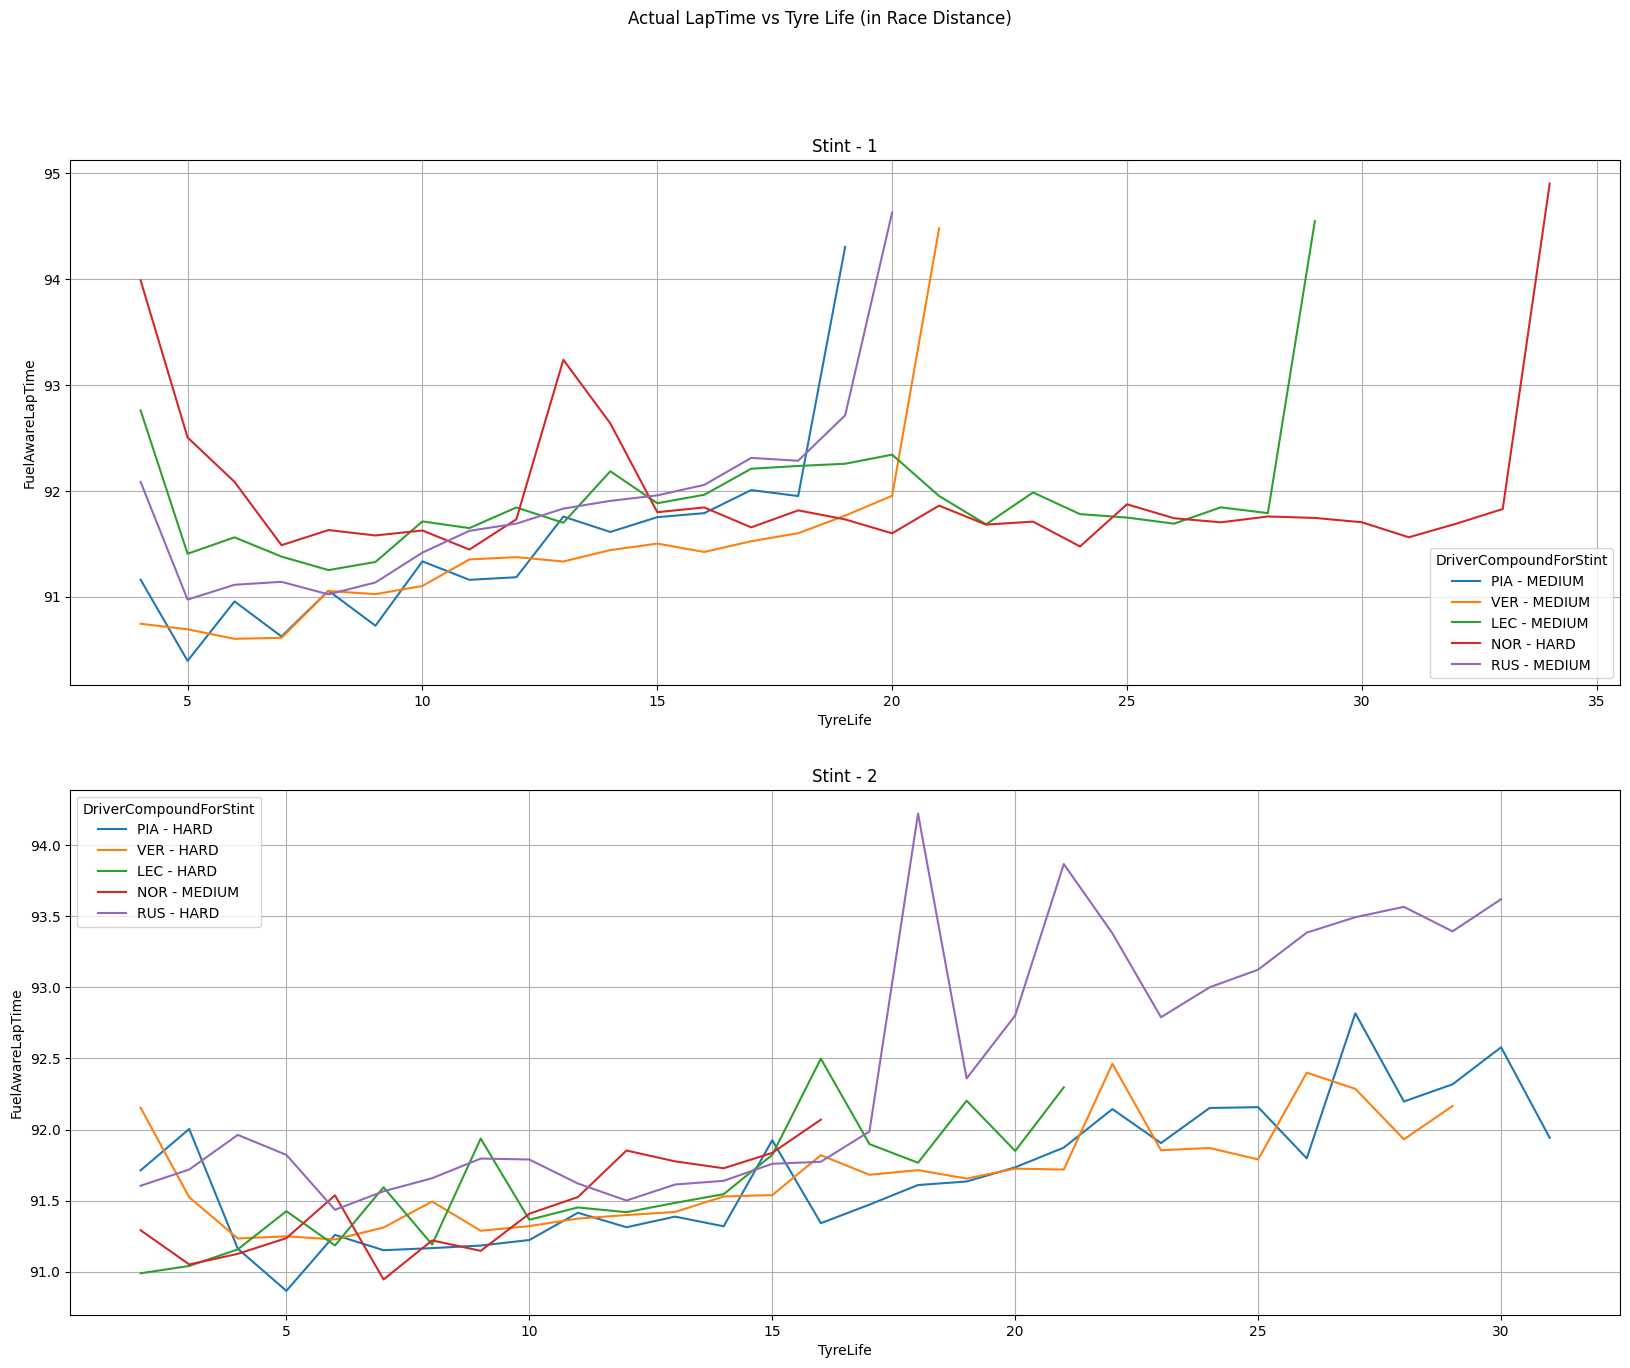

In [ ]:
fig = plt.figure(figsize=(20, 15))
axes = fig.subplots(nrows=2, ncols=1)
axes = axes.flatten()

# Figure-Level Title
fig.suptitle("Actual LapTime vs Tyre Life (in Race Distance)")

# # Stint - 1 Pace and Tyre Degredation
sns.lineplot(
    data=filtered_quick_race_laps[filtered_quick_race_laps["Stint"] == 1.0],
    x="TyreLife",
    y="FuelAwareLapTime",
    hue="DriverCompoundForStint",
    ax=axes[0]
)
axes[0].set_title("Stint - 1")
axes[0].grid()

# # Stint - 2 Pace and Tyre Degredation
sns.lineplot(
    data=filtered_quick_race_laps[filtered_quick_race_laps["Stint"] == 2.0],
    x="TyreLife",
    y="FuelAwareLapTime",
    hue="DriverCompoundForStint",
    ax=axes[1]
)
axes[1].set_title("Stint - 2")
axes[1].grid()

plt.show()

**Inference**
- Stint - 1:
*Note: Leclerc needs to be analysed further as he went long on a medium with good pace.*
    - `Verstappen`: by far has the best tyre deg on the Mediums of the top 5 where 3 other drivers including himself were on the same tyre.
    - `Piastri` and `Leclerc`: Piastri on similar strategy as Max had the second best tyre deg, while Leclerc also had amazing tyre deg considering he went atleast 8 laps longer that max on the same tyre.
    - `Russel`: Had the worst tyre deg of the medium strategy bunch having pushed harder / poor tyre management / dirty air earlier in the stint.
    - `Norris`: On the opposite strategy went longer on the hards which took their time to get into the tyre window thus the average time lost earlier in the stint is massive since the laptime are slower that Russel. Further might have been a mistake lap 13 identified by the spike however, hards have good durability so he was able to pull it back later in the stint by lapping the best pace of the mediums for 20 laps before stint 2.

- Stint - 2:
*Note: Overall there doesn't seem to be much distinction between the mediums (NOR) and hards of the rest during the second stint could be attributed to better track evolution and provisionally the drivers on hards bringing the tyre's to their operating window fast and well.*
    - `Verstappen` and `Piastri`: Both drivers have identical pace throughout the stint however, Piastri seems to have pushed / reached the window earlier since he pitted first during the first stint. However, Piastri pace is spiky during the stint prospectivly overtakes (from traffic or track position). Verstappen has a smoother curve indicating sustained pace for longer with spikes towards the end of the stint, provisonally overtakes (from traffic or track position).
    - `Leclerc`: Having pitted later he had a stonking out lap to push the hards to the operating window quicker than others since he had lesser distance to cover on them. He has spikes which should definitely be overtakes for position due to the strategy he was on but the pace is really good inline with VER and PIA.
    - `Russel`: Seems to have the worst pace on the hard both getting them into the window and then utilising the grip later into the stint with maybe mistakes or traffic later in the stint (large spikes and increased slope towards the end of the stint).
    - `Norris`: On the opposite startegy go into the operating window quickly too but LEC was still better. Norris was mostly inline in pace with the hard runners with minor spikes for overtaking traffic or gaining track position with ease. Having pitted last in the first stint he was in good pace with the Medium front runners but the tyre gains were marginal.


In [ ]:

for driver in filtered_quick_race_laps["Driver"].unique():
    print(get_driver_color(identifier=driver, session=jeddah_race))

req            INFO 	Using cached data for driver_info


#ff8000
#0600ef
#e80020
#ff8000
#27f4d2


**Quantifying the Tyre Degredation by Stint (for the Front Runners)**

In [ ]:
def tyredeg_coeff(tyre_life: pd.Series, fuel_aware_laptime: pd.Series) -> np.ndarray:
    """Calculates the linear polynomial coefficients for tyre
    degredation for each driver wrt each stint during the race and returns them."""

    coeffs = np.polyfit(
        x=tyre_life,
        y=fuel_aware_laptime,
        deg=1
    )

    return coeffs

driver_deg_coeffs = filtered_quick_race_laps.groupby(["Driver", "Stint"])[["TyreLife", "FuelAwareLapTime"]].apply(  # type: ignore
    lambda x: tyredeg_coeff(tyre_life=x.TyreLife, fuel_aware_laptime=x.FuelAwareLapTime)  # type: ignore
)
driver_deg_coeffs

Driver  Stint
LEC     1.0          [0.03134888736328015, 91.4311071212751]
        2.0         [0.05831810385203326, 90.93453458674162]
NOR     1.0      [-0.0035771973225782704, 92.05495777452252]
        2.0          [0.06298128334285684, 90.8822787563676]
PIA     1.0          [0.1471318102423491, 89.79264719711301]
        2.0          [0.04079505408035503, 91.0183100931675]
RUS     1.0         [0.13043726872548828, 90.30964241124707]
        2.0         [0.08505445285753761, 91.06172872338281]
VER     1.0         [0.12141312800660309, 89.90243479138412]
        2.0        [0.030491688867868634, 91.21014986643372]
Name: (TyreLife, FuelAwareLapTime), dtype: object

/Users/purplelightning/Development/Racing-all-Along/.venv/lib/python3.13/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


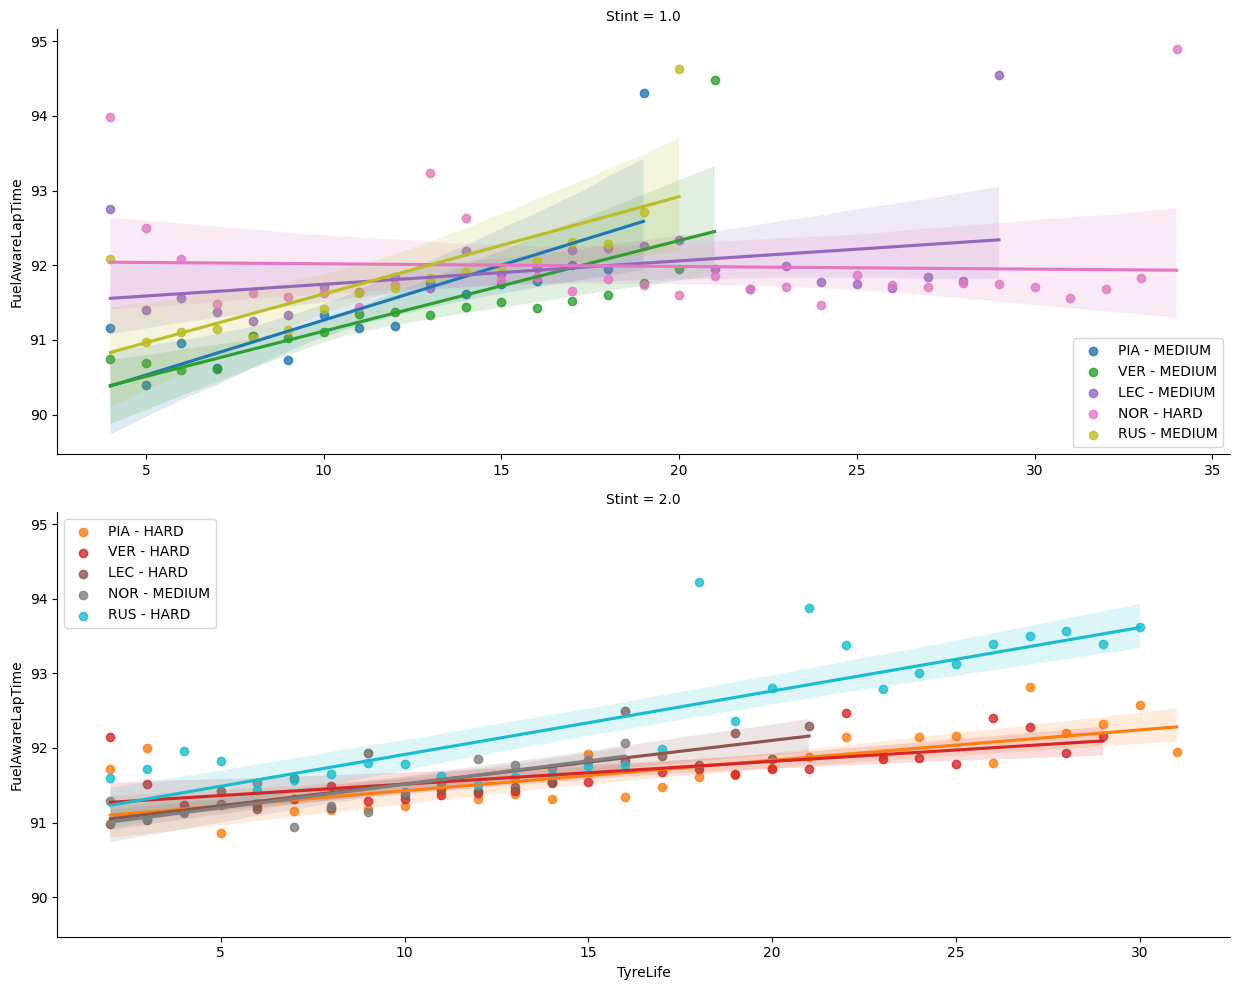

In [ ]:
# Visually confirming the coefficients
grid = sns.lmplot(
    data=filtered_quick_race_laps,
    x="TyreLife",
    y="FuelAwareLapTime",
    hue="DriverCompoundForStint",
    row="Stint",
    height=5,
    aspect=2.5,
    legend=False,
    facet_kws={"sharex": False}
)

for ax in grid.axes.flatten():
    ax.legend()

plt.show()

array([[<Axes: title={'center': 'Stint = 1.0'}, ylabel='FuelAwareLapTime'>],
       [<Axes: title={'center': 'Stint = 2.0'}, xlabel='TyreLife', ylabel='FuelAwareLapTime'>]],
      dtype=object)